In [ ]:
# atrinkti 10 populiariausių gamintojų iš autopliuslt,
#  pateikti tokius stulpelius - gamintojas, vidutinė kaina, vidutinė rida,
#  vidutinis amžius, modelių kiekis.
#  Gautus rezultatus surašyti į SQLite duomebazę, pavadinimu "Testas.db", lentelės pavadinimas kokį sugalvosite. Viską turi atlikti python kodas.
#  PANDAS NEGALIMA NAUDOTI, viską atlikite per cursor() objektus.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px
import psycopg2

In [17]:

import sqlite3
from datetime import datetime

DB = cnt.connect(
    host = '88.223.121.130',
    user='user',
    password='slaptazodis',
    port=3306,
    database='works'
    )
C=DB.cursor()


C.execute("""
    select gamintojas, 
avg(cast(replace(price, ' ', '') as unsigned)) as avg_price, 
avg(cast(rida as float)) as avg_rida, 
avg(year(now()) - left(pagaminimo_data, 4)) as avg_amzius,
count(distinct id) as modeliu_kiekis
from autopliuslt
where rida != 'Nenurodyta'
group by gamintojas
order by modeliu_kiekis desc
limit 10;
""")

top_manufacturers = C.fetchall()

C.close()

sqlite_conn = sqlite3.connect('Testas.db')
sqlite_cursor = sqlite_conn.cursor()

sql ="""
    create table if not exists TopManufacturers (
        gamintojas text not null,
        avg_price real not null,
        avg_rida real not null,
        avg_amzius real not null,
        modeliu_kiekis integer not null
    );
"""
sqlite_cursor.execute(sql)
for manufacturer in top_manufacturers:
    sqlite_cursor.execute("""
        insert into TopManufacturers (gamintojas, avg_price, avg_rida, avg_amzius, modeliu_kiekis)
        values (?, ?, ?, ?, ?);
    """, manufacturer)
sqlite_conn.commit()

sqlite_cursor.close()
sqlite_conn.close()

print("__")


__


In [ ]:
# pandas ir JSON:

#  https://data.gov.lt/datasets/509/

# nuskaitykite JSON failą -  2023 metus

# konvertuokite dataLaikas stulpelį į datetime
#  pd.to_datetime(df[stulpelis])

# pridėkite naują stulpelį su paros laikais (rytas, vakaras ...)
# pridėkite naują stulplelį, kur būtų tik įvykio valanda
# Vizualizuokite, kuriuo paros laiku, kurią valandą įvyksta daugiausiai eismo įvykių

# sekantiems klausimams patys sugalvojate tinkamiausias vizualizacijas
# Vyrų ar moterų buvo daugiau, sukėlusių eismo įvykį?
#  koks vidutinis kaltininkų amžius?
# Kokiomis baudų rūšimis buvo nubausti vyrai/moterys (administracinė, baudžiamoji) (teisenosStadijaBusena)

In [19]:
df = pd.read_json('../../DATA/ei_2023_12_31.json')
df.head(1)

,registrokodas,dataLaikas,registravimoData,paskutinioRedagavimoLaikas,iskaitinis,rusis,schema1,schema2,dalyviuSkaicius,zuvusiuSkaicius,...,kelioElementas2,privalomasLeistinasGreitis,leistinasGreitis,neblaivusKaltininkai,apsvaigeKaltininkai,atsisakeTikrintisKaltininkai,ilguma,platuma,eismoDalyviai,eismoTranspPreimone
0,07-23-9588945,2023-01-01 00:27,2023-01-01 01:04,2023-03-31 12:14,0,Kiti eismo įvykiai,Kiti eismo įvykiai,Kiti eismo įvykiai,2,0,...,None,1,40.0,Ne,Ne,Ne,6063990.0,579292.0,"[{'dalyvisId': 48690423, 'kategorija': 'Kiti',...","[{'tpId': 33646065, 'regValstybe': 'Lietuva', ..."


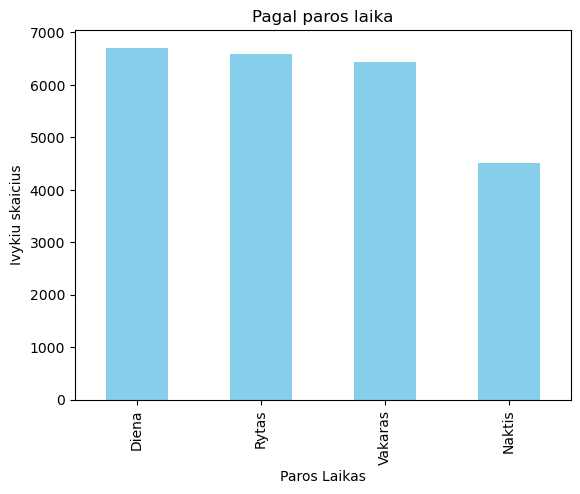

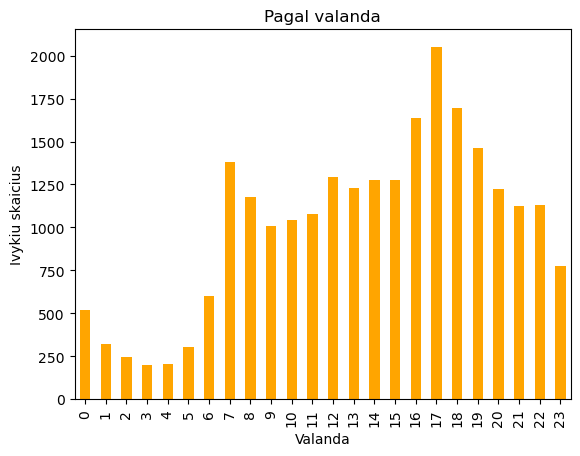

In [31]:
df['dataLaikas'] = pd.to_datetime(df['dataLaikas'])


def paros_laikas(hour):
    if 5 <= hour < 12:
        return 'Rytas'
    elif 12 <= hour < 17:
        return 'Diena'
    elif 17 <= hour < 21:
        return 'Vakaras'
    else:
        return 'Naktis'

df['parosLaikas'] = df['dataLaikas'].dt.hour.apply(paros_laikas)

df['valanda'] = df['dataLaikas'].dt.hour

df.head(1)


df['parosLaikas'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Pagal paros laika')
plt.xlabel('Paros Laikas')
plt.ylabel('Ivykiu skaicius')
plt.show()

df['valanda'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Pagal valanda')
plt.xlabel('Valanda')
plt.ylabel('Ivykiu skaicius')
plt.show()



In [38]:
# print(df['eismoDalyviai'][0][0])

# lytis = df['eismoDalyviai'][0][0]['lytis']
# kaltininkas =  df['eismoDalyviai'][0][0]['kaltininkas']

# if kaltininkas == 'taip':



In [67]:
def kaltininko_lytis(x):
    for p in x:  
        if p.get('kaltininkas') == 'taip':  
            return p[0][0].get('lytis')
    return None

df['kLytis'] = df['eismoDalyviai'].apply(kaltininko_lytis)
print(df['kLytis'])
# df['sukLytis'].value_counts().plot(kind='bar', color=['lightblue', 'pink'])
# plt.title('Vyru ar Moteru')
# plt.xlabel('Lytis')
# plt.ylabel('Skaicius')
# plt.show()

0        None
1        None
2        None
3        None
4        None
         ... 
24235    None
24236    None
24237    None
24238    None
24239    None
Name: kLytis, Length: 24240, dtype: object


In [30]:
print(df['eismoDalyviai'].head())

0    [{'dalyvisId': 48690423, 'kategorija': 'Kiti',...
1    [{'dalyvisId': 48474937, 'kategorija': 'Automo...
2    [{'dalyvisId': 48480520, 'kategorija': 'Automo...
3    [{'dalyvisId': 48474443, 'kategorija': 'Automo...
4    [{'dalyvisId': 48579303, 'kategorija': 'Automo...
Name: eismoDalyviai, dtype: object


In [40]:
motSkaicius=0
vyrSkaicius=0
for i in df['eismoDalyviai']:
    for j in i:
        if j['kaltininkas']== 'Taip':
            if j['lytis'] == 'Vyras':
                vyrSkaicius = vyrSkaicius+1
            if j['lytis']== 'Moteris':
                motSkaicius = motSkaicius+1
print(motSkaicius)
print(vyrSkaicius)

# Mantas Dzimidas 9:47 PM
def amzius(x):
    for i in x:
        if i['kaltininkas'] == 'Taip':
            return i['amzius']

2889
9173


kLytis
Vyras      8887
Moteris    2778
Name: count, dtype: int64


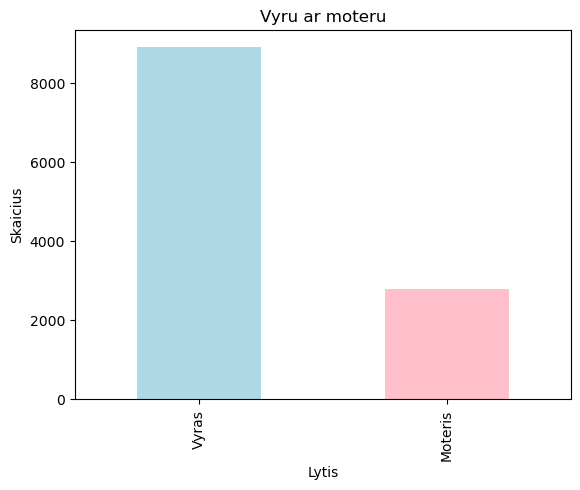

In [73]:
def kaltininko_lytis(x):
    for j in x:
        if j['kaltininkas'] == 'Taip':
            return j['lytis']  
    return None  

df['kLytis'] = df['eismoDalyviai'].apply(kaltininko_lytis)

print(df['kLytis'].value_counts())

df['kLytis'].value_counts().plot(kind='bar', color=['lightblue', 'pink'])
plt.title('Vyru ar moteru')
plt.xlabel('Lytis')
plt.ylabel('Skaicius')
plt.show()

In [ ]:
# atsisiųskite visus 
#  duomenis iš 
# https://data.gov.lt/datasets/509/
# 
# Užduotys:
# nuskaitykite visus failus į pandas DF (vienas DF vienam failui)
# Suraskite ir pateikite kitimą kas metus šių kriterijų:
# Dalyvių kiekis kiekvienais metais
# Apgadintų TP kiekis kas metus
# Žuvusių kiekis kiekvienais metais
#  Sužeistų kiekis kiekvienais metais
# Neblaivių bei apsvaigusių kaltininkų kiekio kaita kas metus
# Suraskite 3 populiariausias eismo įvykių schemas! 2023 metais (stulpelis schema2)
# ir pavaizduokite kitimą kas metus.
#  parodykite, kaip kito vyrų, moterų sukeltų EI kiekiai kas metus.
# parodykite, kaip kito neblaivių vyrų, moterų sukeltų EI kiekiai kas metus

In [83]:
file_paths = ['../../DATA/ei_2023_12_31.json', r'C:\Users\Batia\Downloads\ei_2022_12_31.json', r'C:\Users\Batia\Downloads\ei_2021_12_31.json', r'C:\Users\Batia\Downloads\ei_2020_12_31.json', r'C:\Users\Batia\Downloads\ei_2019_12_31.json',r'C:\Users\Batia\Downloads\ei_2018_12_31.json',r'C:\Users\Batia\Downloads\ei_2017_12_31.json',r'C:\Users\Batia\Downloads\ei_2016_12_31.json',r'C:\Users\Batia\Downloads\ei_2015_12_31.json',r'C:\Users\Batia\Downloads\ei_2014_12_31.json', r'C:\Users\Batia\Downloads\ei_2013_12_31.json']

dfs = []

for file in file_paths:
        df = pd.read_json(file)
        dfs.append(df)

for df in dfs:
    df['metai'] = pd.to_datetime(df['dataLaikas']).dt.year

# df.head(1)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21946 entries, 0 to 21945
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   registrokodas                 21946 non-null  object 
 1   dataLaikas                    21946 non-null  object 
 2   registravimoData              21946 non-null  object 
 3   paskutinioRedagavimoLaikas    21297 non-null  object 
 4   iskaitinis                    21946 non-null  int64  
 5   rusis                         21297 non-null  object 
 6   schema1                       21297 non-null  object 
 7   schema2                       21297 non-null  object 
 8   dalyviuSkaicius               21297 non-null  float64
 9   zuvusiuSkaicius               21946 non-null  int64  
 10  zuvVaiku                      3 non-null      float64
 11  suzeistuSkaicius              21946 non-null  int64  
 12  suzeistaVaiku                 3 non-null      float64
 13  t

In [88]:
pd.set_option('display.max_columns', 52)

In [105]:
df.head(5)

,registrokodas,dataLaikas,registravimoData,paskutinioRedagavimoLaikas,iskaitinis,rusis,schema1,schema2,dalyviuSkaicius,zuvusiuSkaicius,zuvVaiku,suzeistuSkaicius,suzeistaVaiku,tpSkaicius,policijosTpSkaicius,apgadintuTpSkaicius,apgadintuPolicijosTpSkaicius,policijosIstaigaL1,policijosIstaigaL2,iforminusiIstaigaL1,iforminusiIstaigaL2,ivykioVieta,vietosSavivaldybeTipas,savivaldybe,gatve,namas,...,kelioReiksme,atstumas,dangosRusis,dangosBukle,parosMetas,kelioApsvietimas,meteoSalygos,kitosOroSalygos,kelioGatvesKreive,nuliamentisVeiksnys,kitiNuliamentysVeiksniai,atitvarai,sankryzosTipas,kelioElementas1,kelioElementas2,privalomasLeistinasGreitis,leistinasGreitis,neblaivusKaltininkai,apsvaigeKaltininkai,atsisakeTikrintisKaltininkai,ilguma,platuma,eismoDalyviai,eismoTranspPreimone,metai,dalyviu_skaicius
0,07-22-9565141,2021-12-31 22:00,2022-01-01 00:30,2022-01-01 00:39,0,Kiti eismo įvykiai,Nuvažiavimai nuo kelio,"Nuvažiavimai nuo kelio į kairę, kai kelio ving...",1.0,0,0,0,0,1.0,NaN,1.0,NaN,Kauno AVPK,None,Kauno AVPK,Kauno AVPK KPV,"Kaunas, S. Dariaus ir S. Girėno 124",MIESTO_SAVIVALDYBE,Kauno miesto sav.,S. Dariaus ir S. Girėno,124,...,None,NaN,"Asfaltbetonis, cementbetonis",Šlapia,Tamsus paros metas,Neįrengtas,Lietus,[],Vingiuota nuokalnė,None,[],Nėra,None,None,None,1,50.0,Ne,Ne,Ne,6083759.0,491606.0,"[{'dalyvisId': 47756477, 'kategorija': 'Automo...","[{'tpId': 32912177, 'regValstybe': 'Lietuva', ...",2021,1
1,07-22-9565142,2022-01-01 00:40,2022-01-01 01:28,2022-01-03 13:49,0,Susidūrimas,Kiti eismo įvykiai,Susidūrimas su stovinčia TP,2.0,0,0,0,0,2.0,NaN,2.0,NaN,Klaipėdos AVPK Klaipėdos m. PK,None,Klaipėdos AVPK Klaipėdos m. PK,None,"Klaipėda, Audros 8",MIESTO_SAVIVALDYBE,Klaipėdos miesto sav.,Audros,8,...,None,NaN,"Asfaltbetonis, cementbetonis",Šlapia,Tamsus paros metas,Neįjungtas,Lietus,[],Tiesus horizontalus ruožas,None,[],Nėra,None,None,None,1,20.0,Ne,Ne,Ne,6181902.0,317439.0,"[{'dalyvisId': 47759080, 'kategorija': 'Automo...","[{'tpId': 32913457, 'regValstybe': 'Lietuva', ...",2022,2
2,07-22-9565143,2022-01-01 02:02,2022-01-01 02:29,2022-01-01 02:29,0,Užvažiavimas ant gyvūno,Kiti eismo įvykiai,Užvažiavimas ant gyvūno,1.0,0,0,0,0,1.0,NaN,1.0,NaN,Klaipėdos AVPK Klaipėdos r. PK,None,Klaipėdos AVPK Klaipėdos r. PK,None,"Klaipėdos rajono sav., Stragnų II k., Protneši...",SAVIVALDYBE,Klaipėdos rajono sav.,Protnešių,None,...,Krašto keliai,204.00,"Asfaltbetonis, cementbetonis",Šlapia,Tamsus paros metas,Neįrengtas,Apsiniaukę,[],Tiesus horizontalus ruožas,None,[],Nėra,None,None,None,1,90.0,Ne,Ne,Ne,6161589.0,333263.0,"[{'dalyvisId': 47756490, 'kategorija': 'Automo...","[{'tpId': 32912184, 'regValstybe': 'Lietuva', ...",2022,1
3,07-22-9565144,2022-01-01 01:53,2022-01-01 02:34,2022-12-20 09:44,0,Apvirtimas,Nuvažiavimai nuo kelio,Nuvažiavimai nuo kelio į dešinę tiesiame ruože,1.0,0,0,0,0,1.0,NaN,1.0,NaN,Vilniaus AVPK Švenčionių r. PK,None,Vilniaus AVPK Švenčionių r. PK,None,Švenčionių rajono sav. Krašto keliai Vilnius-Š...,SAVIVALDYBE,Švenčionių rajono sav.,None,None,...,Krašto keliai,73.27,"Asfaltbetonis, cementbetonis",Apledėjusi,Tamsus paros metas,Neįrengtas,Lijundra,[],Tiesus horizontalus ruožas,None,[],Nėra,None,None,None,1,90.0,Ne,Ne,Ne,6104844.0,630436.0,"[{'dalyvisId': 48447053, 'kategorija': 'Automo...","[{'tpId': 33386413, 'regValstybe': 'Lietuva', ...",2022,1
4,07-22-9565145,2021-12-31 12:35,2022-01-01 02:52,2022-01-01 02:55,0,Užvažiavimas ant kliūties,Kiti eismo įvykiai,Kiti eismo įvykiai,1.0,0,0,0,0,1.0,NaN,1.0,NaN,Kauno AVPK,None,Kauno AVPK,None,"Kauno rajono sav., Didžiųjų Ibėnų k., Ąžuolų 52",SAVIVALDYBE,Kauno rajono sav.,Ąžuolų,52,...,None,NaN,"Asfaltbetonis, cementbetonis",Šlapia,Tamsus paros metas,Įjungtas,Rūkas,[],Tiesus horizontalus ruožas,None,[],Nėra,None,None,None,1,50.0,Taip,Ne,Ne,6102529.0,495530.0,"[{'dalyvisId': 47756497, 'kategorija': 'Automo...","[{'tpId': 32912187, 'regValstybe': 'Lietuva', ...",2021,1


    Metai  Dalyviu_skaicius
0    2021             40012
1    2022             39895
2    2023             40981
3    2015             35425
4    2016             37443
5    2020             38655
6    2019             48704
7    2017             36998
8    2018             42382
9    2011                83
10   2014             35106
11   2012               209
12   2013             37139
13   2010                15


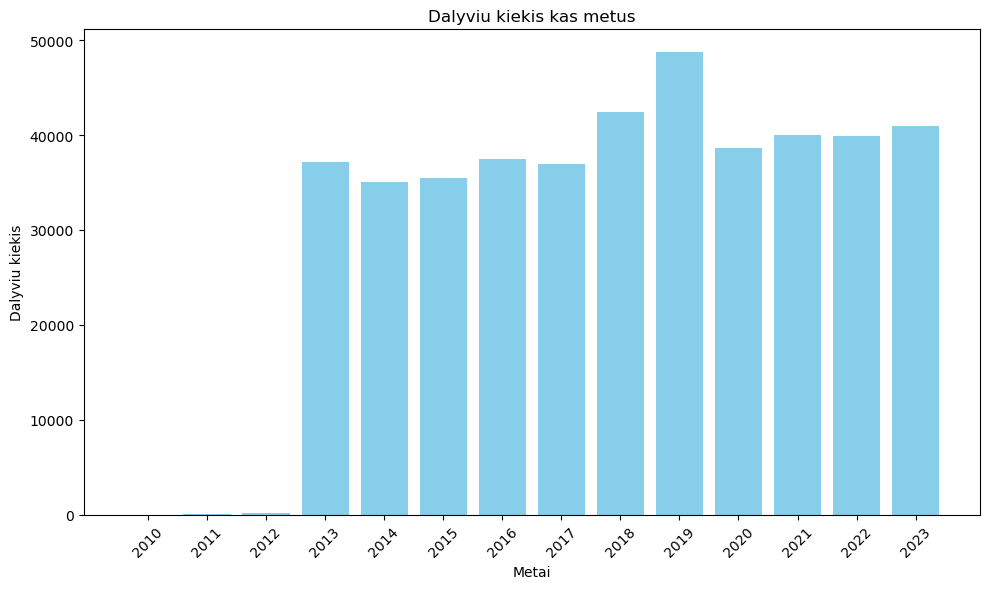

In [121]:
dalyviu_per_metus = {}

for df in dfs:
    df['dalyviu_skaicius'] = df['eismoDalyviai'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    df = df[df['metai'] != 1899]
    yearly_data = df.groupby('metai')['dalyviu_skaicius'].sum()
    
    for year, count in yearly_data.items():
        if year in dalyviu_per_metus:
            dalyviu_per_metus[year] += count
        else:
            dalyviu_per_metus[year] = count

dalyviu_per_metus_df = pd.DataFrame(list(dalyviu_per_metus.items()), columns=['Metai', 'Dalyviu_skaicius'])

print(dalyviu_per_metus_df)

plt.figure(figsize=(10, 6))
plt.bar(dalyviu_per_metus_df['Metai'], dalyviu_per_metus_df['Dalyviu_skaicius'], color='skyblue')
plt.title('Dalyviu kiekis kas metus')
plt.xlabel('Metai')
plt.ylabel('Dalyviu kiekis')
plt.xticks(dalyviu_per_metus_df['Metai'], rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# Apgadintų TP kiekis kas metus

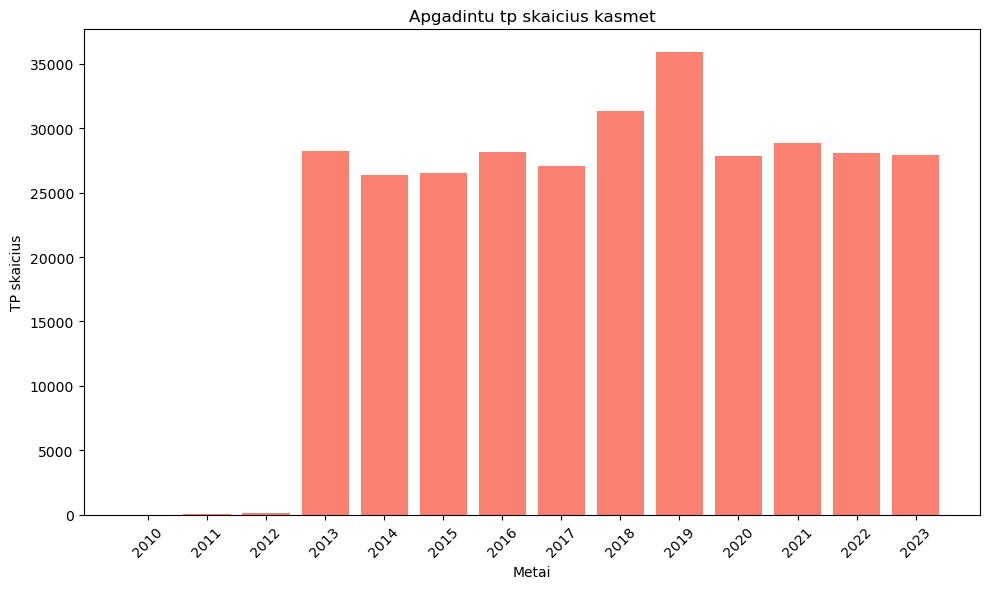

In [120]:
apgadintu_tp_per_metus = {}


for df in dfs:
    df = df[(df['metai'] != 1899) & (df['apgadintuTpSkaicius'].notna())]
    yearly_data = df.groupby('metai')['apgadintuTpSkaicius'].sum()

    for year, count in yearly_data.items():
        if year in apgadintu_tp_per_metus:
            apgadintu_tp_per_metus[year] += count
        else:
            apgadintu_tp_per_metus[year] = count
apgadintu_tp_per_metus_df = pd.DataFrame(list(apgadintu_tp_per_metus.items()), columns=['Metai', 'Apgadintu_TP_skaicius'])


plt.figure(figsize=(10, 6))
plt.bar(apgadintu_tp_per_metus_df['Metai'], apgadintu_tp_per_metus_df['Apgadintu_TP_skaicius'], color='salmon')
plt.xlabel('Metai')
plt.ylabel('TP skaicius')
plt.title('Apgadintu tp skaicius kasmet')
plt.xticks(apgadintu_tp_per_metus_df['Metai'], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Žuvusių kiekis kiekvienais metais

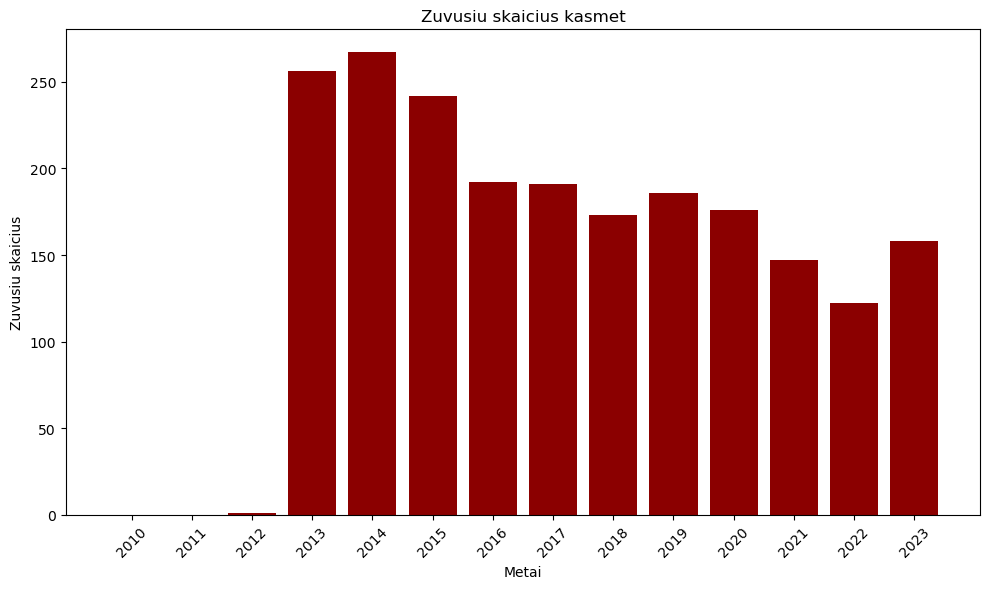

In [123]:
zuvusiu_per_metus = {}

for df in dfs:
    df = df[(df['metai'] != 1899) & (df['zuvusiuSkaicius'].notna())]
    yearly_data = df.groupby('metai')['zuvusiuSkaicius'].sum()
    for year, count in yearly_data.items():
        if year in zuvusiu_per_metus:
            zuvusiu_per_metus[year] += count
        else:
            zuvusiu_per_metus[year] = count

zuvusiu_per_metus_df = pd.DataFrame(list(zuvusiu_per_metus.items()), columns=['Metai', 'Zuvusiu_skaicius'])


plt.figure(figsize=(10, 6))
plt.bar(zuvusiu_per_metus_df['Metai'], zuvusiu_per_metus_df['Zuvusiu_skaicius'], color='darkred')
plt.xlabel('Metai')
plt.ylabel('Zuvusiu skaicius')
plt.title('Zuvusiu skaicius kasmet')
plt.xticks(zuvusiu_per_metus_df['Metai'], rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#  Sužeistų kiekis kiekvienais metais

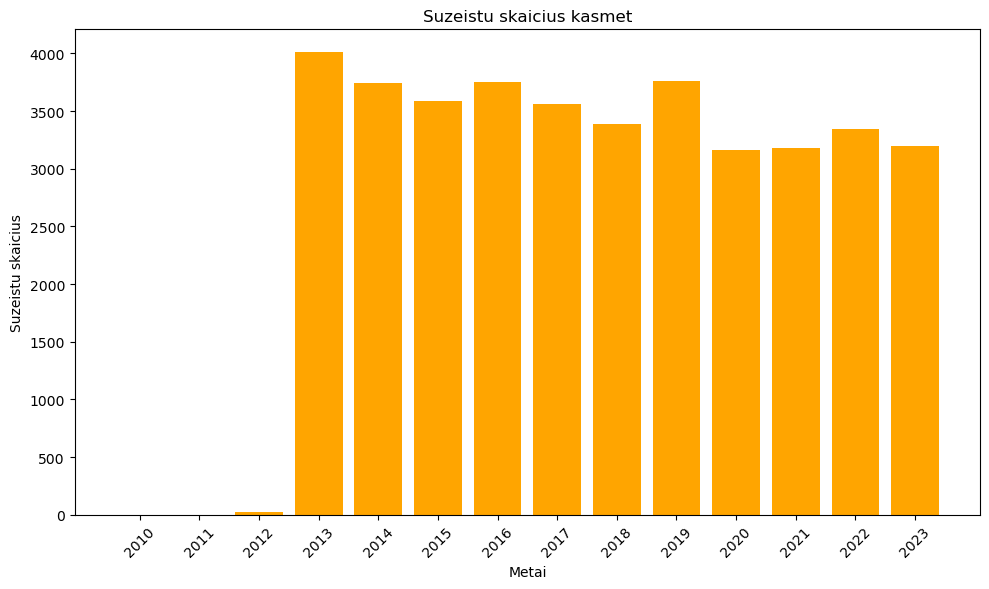

In [125]:
suzeistu_per_metus = {}

for df in dfs:
    df = df[(df['metai'] != 1899) & (df['suzeistuSkaicius'].notna())]
    yearly_data = df.groupby('metai')['suzeistuSkaicius'].sum()
    for year, count in yearly_data.items():
        if year in suzeistu_per_metus:
            suzeistu_per_metus[year] += count
        else:
            suzeistu_per_metus[year] = count

suzeistu_per_metus_df = pd.DataFrame(list(suzeistu_per_metus.items()), columns=['Metai', 'Suzeistu_skaicius'])

plt.figure(figsize=(10, 6))
plt.bar(suzeistu_per_metus_df['Metai'], suzeistu_per_metus_df['Suzeistu_skaicius'], color='orange')
plt.xlabel('Metai')
plt.ylabel('Suzeistu skaicius')
plt.title('Suzeistu skaicius kasmet')
plt.xticks(suzeistu_per_metus_df['Metai'], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Neblaivių bei apsvaigusių kaltininkų kiekio kaita kas metus

    Metai  Neblaivus_kaltininkai_sk
0    2021                      1251
1    2022                      1250
2    2023                      1066
3    2015                      1691
4    2016                      1589
5    2020                      1369
6    2019                      1341
7    2017                      1368
8    2018                      1297
9    2014                       565
10   2013                         1


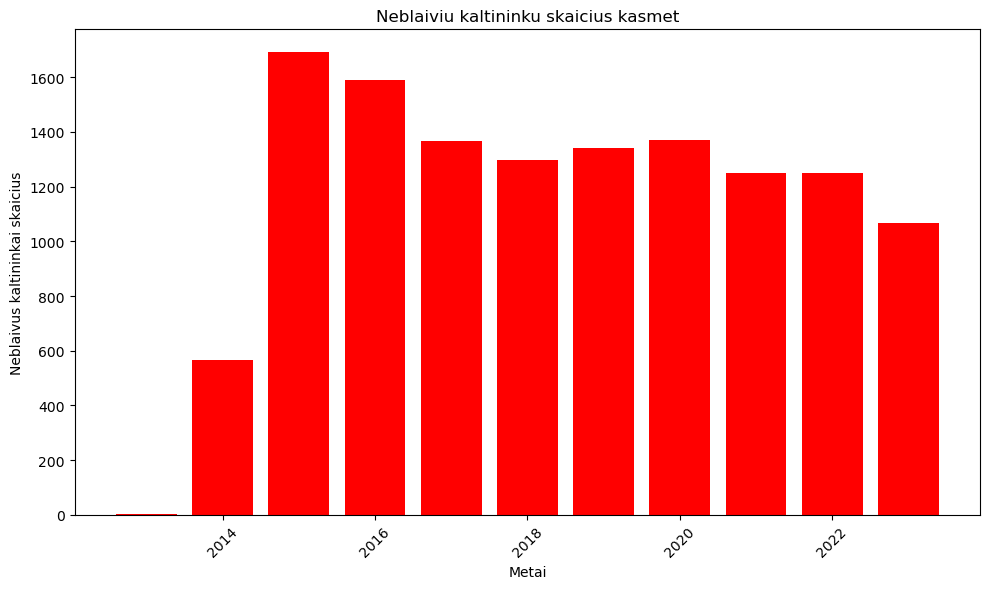

KeyError: 'ApsvaigeKaltininkai'

In [138]:
neblaiviu_per_metus = {}
apsvaigusiu_per_metus = {}

for df in dfs:
    df = df[(df['metai'] != 1899) & (df['neblaivusKaltininkai'].notna()) & (df['apsvaigeKaltininkai'].notna())]
    yearly_data_neblaiviu = df.groupby('metai')['neblaivusKaltininkai'].sum()
    yearly_data_apsvaigusiu = df.groupby('metai')['apsvaigeKaltininkai'].sum()

    for year, count in yearly_data_neblaiviu.items():
        if year in neblaiviu_per_metus:
            neblaiviu_per_metus[year] += count
        else:
            neblaiviu_per_metus[year] = count

    for year, count in yearly_data_apsvaigusiu.items():
        if year in apsvaigusiu_per_metus:
            apsvaigusiu_per_metus[year] += count
        else:
            apsvaigusiu_per_metus[year] = count


neblaiviu_per_metus_df = pd.DataFrame(list(neblaiviu_per_metus.items()), columns=['Metai', 'Neblaivus_kaltininkai'])
apsvaigusiu_per_metus_df = pd.DataFrame(list(apsvaigusiu_per_metus.items()), columns=['Metai', 'Apsvaige_kaltininkai'])


def count_taip(neblaiviu_series):
    return neblaiviu_series.str.count('Taip')

neblaiviu_per_metus_df['Neblaivus_kaltininkai_sk'] = count_taip(neblaiviu_per_metus_df['Neblaivus_kaltininkai'])

print(neblaiviu_per_metus_df[['Metai', 'Neblaivus_kaltininkai_sk']])


plt.figure(figsize=(10, 6))
plt.bar(neblaiviu_per_metus_df['Metai'], neblaiviu_per_metus_df['Neblaivus_kaltininkai_sk'], label='Neblaivus kaltininkai', color='red')
plt.xlabel('Metai')
plt.ylabel('Neblaivus kaltininkai skaicius')
plt.title('Neblaiviu kaltininku skaicius kasmet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


def count_taip_apsvaige(apsvaige_series):
    return apsvaige_series.str.count('Taip')
neblaiviu_per_metus_df['Apsvaige_kaltininkai_sk'] = count_taip_apsvaige(neblaiviu_per_metus_df['ApsvaigeKaltininkai'])

print(neblaiviu_per_metus_df[['Metai', 'Apsvaige_kaltininkai_sk']])

plt.bar(neblaiviu_per_metus_df['Metai'], neblaiviu_per_metus_df['Apsvaige_kaltininkai_sk'], label='Apsvaige Kaltininkai', color='blue')
plt.xlabel('Metai')
plt.ylabel('Neblaivus kaltininkai skaicius')
plt.title('Neblaiviu kaltininku skaicius kasmet')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# GMP duomenų analizė
# https://open-data-ls-osp-sdg.hub.arcgis.com/datasets/b8d1b280f55e45b3b8596d833584c8e5_0/about
# 
# Klausimai:
# Ar buvo mėnesių, kurie išssikirtų gaisringumu?
# Ar buvo mėnesių, kurie išssikirtų didelių gaisrų kiekiu? (2 ir daugiau autocisternos važiuoja) 

# kokios vyraujančios 5 GMP kvietimo priežastys? Pateikite procentinį įvertinimą.
# ar yra mėnesių, išsiskiriančių trukdančių skambučių gausa?
# 
# pateikite top 5-kias priežastis, dėl kurių buvo kviesta policija.
# Pateikite procentinį įvertinimą.

# Pasirinkite 1-ną policijos kvietimo priežastį iš TOP5 ir palyginkite su kvietimais dėl KET, 
# kiekvienam mėnesiui. Ar yra mėnesių, kada dėl KET kviečiama mažiau, 
# nei dėl jūsų pasirinktos priežasties?

In [1]:
import pandas as pd

df = pd.read_csv('../../DATA/GMP.csv')


print(df.head())

           X          Y     ivykio_id  metai  menuo ivykio_kodas  \
0  25.377150  55.015057  d5474d7eb699   2022      6          2.1   
1  25.241877  54.673893  5dbe402b697f   2022      6        6.4.9   
2  25.310431  54.704361  05c214346ad2   2022      6          2.1   
3  25.279104  54.831529  8b6a51ac3bd4   2022      6        6.4.5   
4  24.371120  55.727726  d934a85f1240   2022      6        4.1.6   

  aukstesnis_ivykio_tipas zemesnis_ivykio_tipas  object_id  
0                 BPC-GMP            GMP įvykis          1  
1       Policijos įvykiai        Neklasifikuoti          2  
2                 BPC-GMP            GMP įvykis          3  
3       Policijos įvykiai               Lavonas          4  
4             GMP įvykiai       Gulintis_žmogus          5  


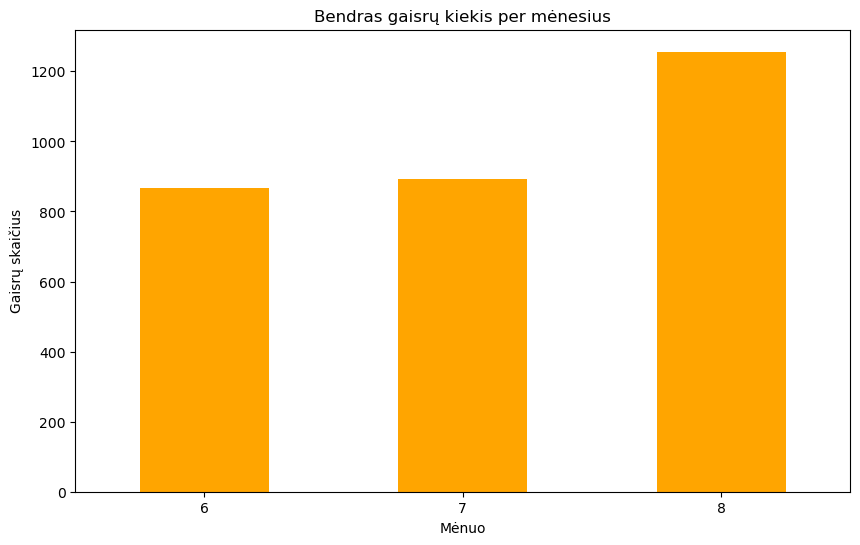

In [5]:

gaisras = df[df['zemesnis_ivykio_tipas'].str.contains('Gaisras', na=False)]


ugnism = gaisras.groupby('menuo').size()


plt.figure(figsize=(10, 6))
ugnism.plot(kind='bar', color='orange')
plt.title('Gaisrai')
plt.xlabel('Menuo')
plt.ylabel('Gaisru skaicius')
plt.xticks(rotation=0)
plt.show()


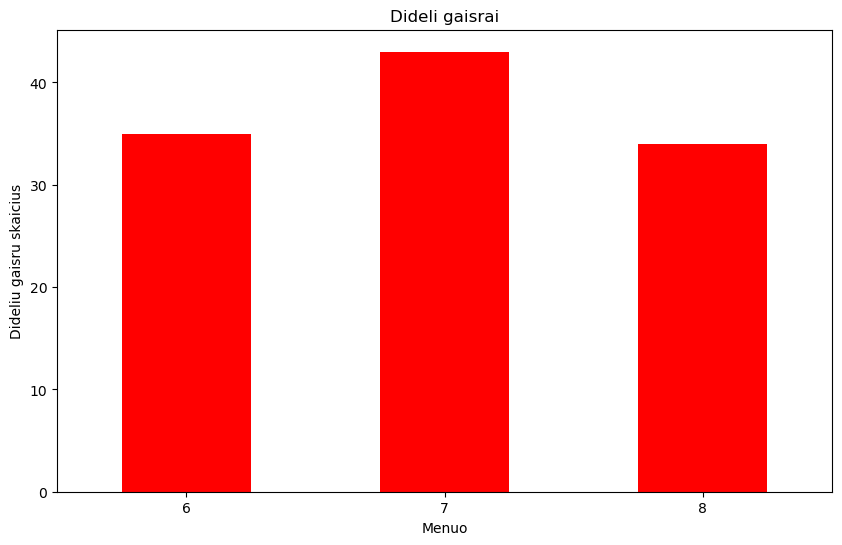

In [19]:
large_fires = df[df['zemesnis_ivykio_tipas'].str.contains('Gaisras 2|Gaisras 3|Gaisras 4|Gaisras 5', na=False)]

# Group by month and count occurrences
large_fires_by_month = large_fires.groupby('menuo').size()

# Plot the results
plt.figure(figsize=(10, 6))
large_fires_by_month.plot(kind='bar', color='red')
plt.title('Dideli gaisrai')
plt.xlabel('Menuo')
plt.ylabel('Dideliu gaisru skaicius')
plt.xticks(rotation=0)
plt.show()

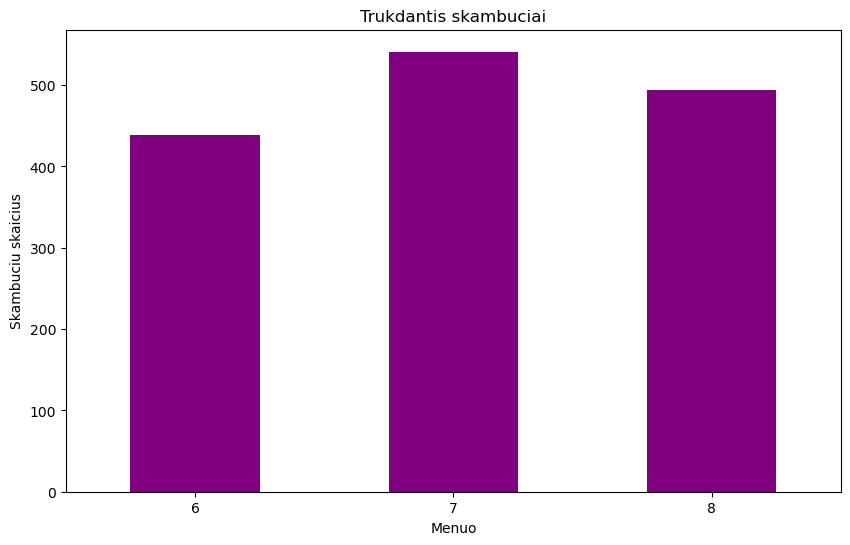

In [7]:
skambuciai = df[df['zemesnis_ivykio_tipas'].str.contains('BPC TRUKDANTIS', na=False)]

skambuciaim = skambuciai.groupby('menuo').size()

# Plot the results
plt.figure(figsize=(10, 6))
skambuciaim.plot(kind='bar', color='purple')
plt.title('Trukdantis skambuciai')
plt.xlabel('Menuo')
plt.ylabel('Skambuciu skaicius')
plt.xticks(rotation=0)
plt.show()


Top 5 GMP
zemesnis_ivykio_tipas
GMP įvykis                              35.529965
Įvairūs viešosios tvarkos pažeidimai    10.904083
KET pažeidimas                           8.088326
Turtinė veika anksčiau                   4.926025
Smurtas artimoje aplinkoje               4.294609
Name: count, dtype: float64


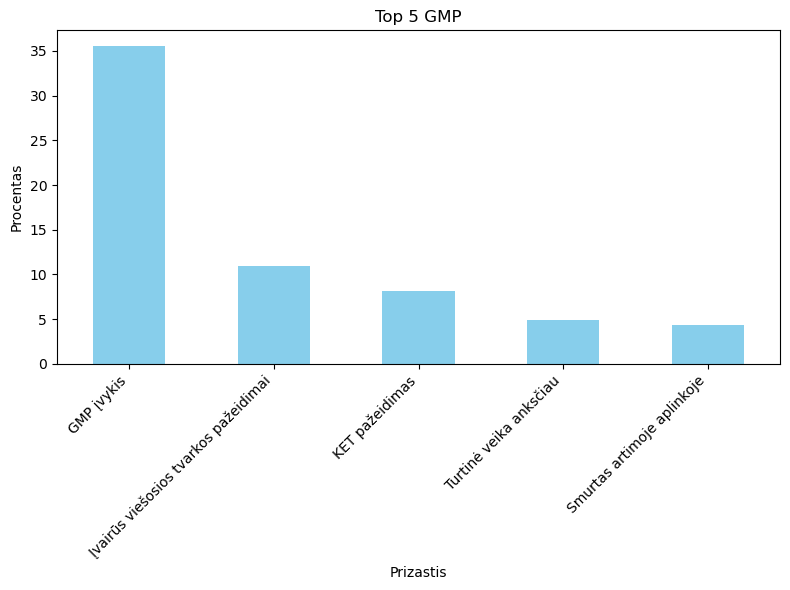

In [9]:
# kokios vyraujančios 5 GMP kvietimo priežastys? Pateikite procentinį įvertinimą



top = df['zemesnis_ivykio_tipas'].value_counts().head(5)
tivykiai = df['zemesnis_ivykio_tipas'].count()
proc = (top / tivykiai) * 100

print("Top 5 GMP")
print(proc)

plt.figure(figsize=(8, 6))
proc.plot(kind='bar', color='skyblue')
plt.title('Top 5 GMP')
plt.xlabel('Prizastis')
plt.ylabel('Procentas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Top 5
zemesnis_ivykio_tipas
Įvairūs viešosios tvarkos pažeidimai    24.140497
KET pažeidimas                          17.906706
Turtinė veika anksčiau                  10.905702
Smurtas artimoje aplinkoje               9.507813
Pavojus eismo saugumui                   5.997558
Name: count, dtype: float64


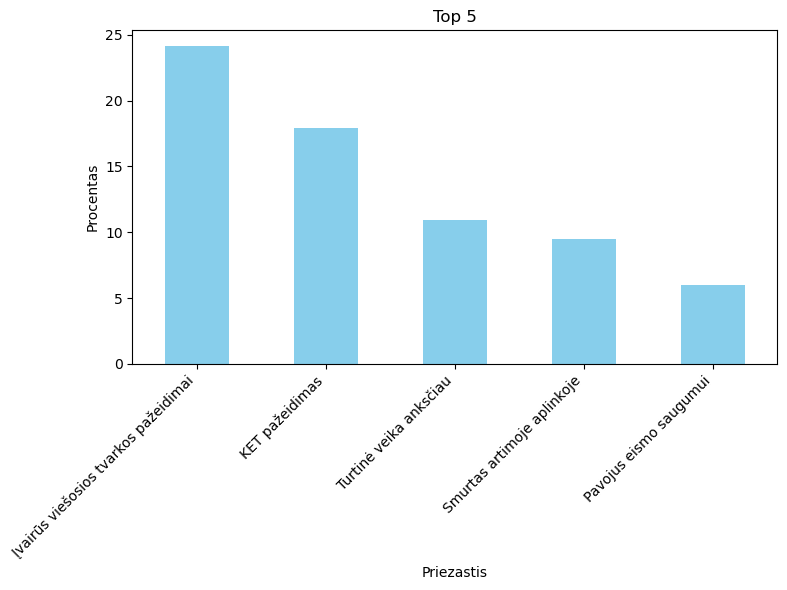

([<matplotlib.patches.Wedge at 0x21ee178e2d0>,
 [Text(-0.984201097406993, 0.49127202226757305, 'Įvairūs viešosios tvarkos pažeidimai'),
  Text(-0.11441057367489535, -1.0940339211520735, 'KET pažeidimas'),
  Text(1.032259242462857, -0.3800537545532329, 'Turtinė veika anksčiau'),
  Text(0.917681944021892, 0.6065145089906764, 'Smurtas artimoje aplinkoje'),
  Text(0.29894671638694237, 1.0585985361606471, 'Pavojus eismo saugumui')],
 [Text(-0.5368369622219962, 0.26796655760049437, '35.3%'),
  Text(-0.06240576745903382, -0.5967457751738583, '26.2%'),
  Text(0.5630504958888309, -0.20730204793812704, '15.9%'),
  Text(0.5005537876483047, 0.33082609581309613, '13.9%'),
  Text(0.16306184530196854, 0.577417383360353, '8.8%')])

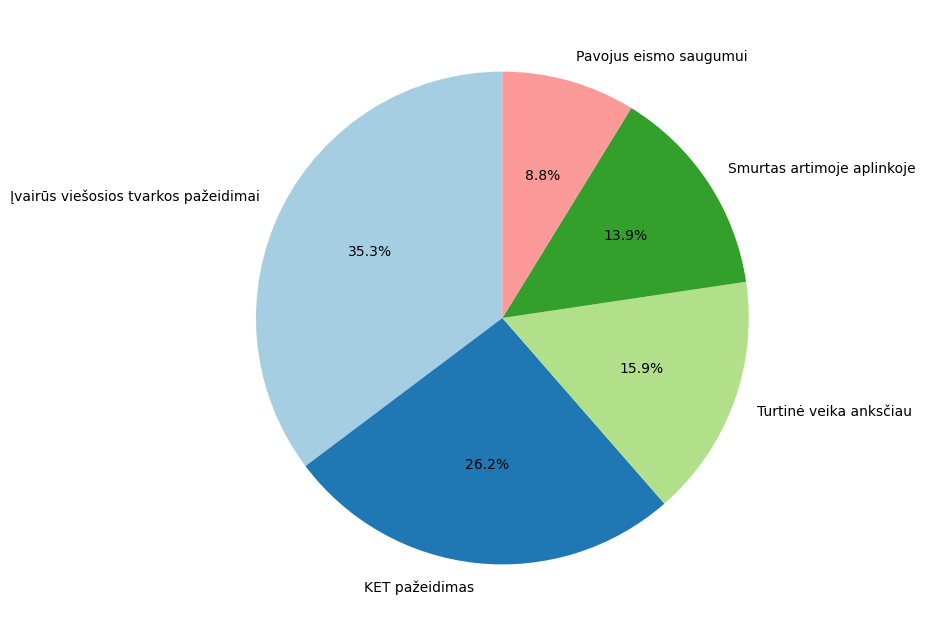

In [17]:
# pateikite top 5-kias priežastis, dėl kurių buvo kviesta policija.
# Pateikite procentinį įvertinimą.



pincidentai = df[df['aukstesnis_ivykio_tipas'] == 'Policijos įvykiai']
top = pincidentai['zemesnis_ivykio_tipas'].value_counts().head(5)
totalincidentai = pincidentai['zemesnis_ivykio_tipas'].count()

proc = (top / totalincidentai) * 100

print("Top 5")
print(proc)


plt.figure(figsize=(8, 6))
proc.plot(kind='bar', color='skyblue')
plt.title('Top 5')
plt.xlabel('Priezastis')
plt.ylabel('Procentas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(proc, labels=proc.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)


In [ ]:
# Pasirinkite 1-ną policijos kvietimo priežastį iš TOP5 ir palyginkite su kvietimais dėl KET,
# kiekvienam mėnesiui. Ar yra mėnesių, kada dėl KET kviečiama mažiau, 
# nei dėl jūsų pasirinktos priežasties?

       Pasirinktas   KET  KET_maziau_negu_pasirinktas
menuo                                                
6             9869  8600                         True
7            11285  8025                         True
8            12262  8162                         True


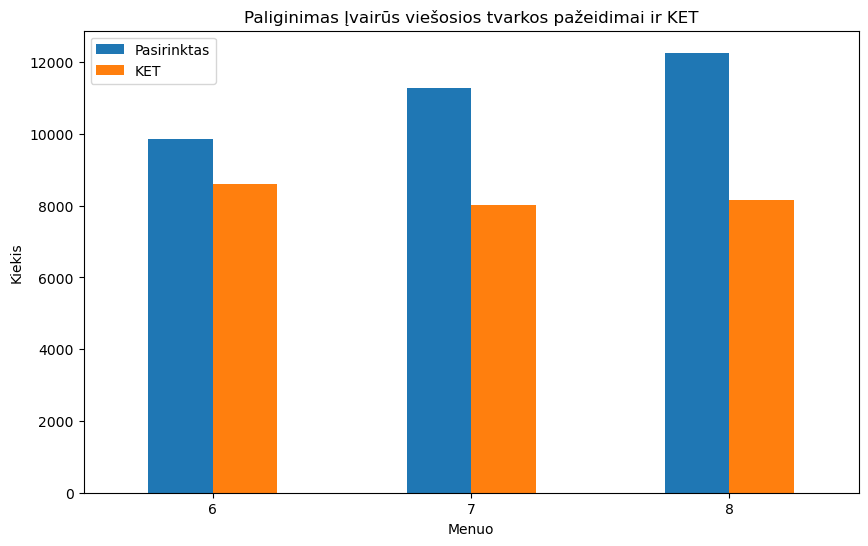

In [25]:

priezastis = proc.index[0]

priezastism = df[(df['aukstesnis_ivykio_tipas'] == 'Policijos įvykiai') & (df['zemesnis_ivykio_tipas'] == priezastis)].groupby('menuo').size()
ketm = df[(df['zemesnis_ivykio_tipas'].str.contains('KET'))].groupby('menuo').size()
palyg = pd.DataFrame({'Pasirinktas': priezastism,'KET': ketm}).fillna(0)
palyg['KET_maziau_negu_pasirinktas'] = palyg['KET'] < palyg['Pasirinktas']
print(palyg)
palyg[['Pasirinktas', 'KET']].plot(kind='bar', figsize=(10, 6))
plt.title(f'Paliginimas {priezastis} ir KET')
plt.ylabel('Kiekis')
plt.xlabel('Menuo')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# https://open-data-ls-osp-sdg.hub.arcgis.com/datasets/27c22303570541fd9dae7299be45d601_0/about
# Ar yra skirtumas tarp to, kas administruoja
# pastatą, ir noro renovuotis? (Suraskite, kiek procentų yra renovavęsi
# pagal administravimo pobūdį)
# Ar galima teigti, kad kuo senesnis pastatas, tuo gyventojai
# nori labiau renovacijos? 
# (pastatų amžius vs renovuotų tokio amžiaus pastatų kiekis)
# kurioje seniūnijoje daugiausiasi renovuotų pastatų?
# kokios trys seniūnijos yra renovacijos priekyje?

In [26]:
print(df['menuo'].unique())

[6 7 8]


In [30]:
df = pd.read_csv(r"C:\Users\Batia\Downloads\Duomenys_apie_Kauno_miesto_daugiabucius.csv")
df.head()

,X,Y,vda_id,seniunija,gatve,namo_nr,butu_sk,negyvenamu_sk,aukstu_sk,namo_plotas,zemes_plotas,statybos_metai,valdymo_forma,valdytojas,admin_pabaiga,ar_perduotas,bukle,atlikti_darbai,object_id,geom
0,NaN,NaN,4fc5a7d3836798b,NaN,Vilniaus g.,24A,NaN,0,NaN,0.00,0.0,NaN,Bendrija,NaN,NaN,1,NaN,NaN,1,NaN
1,496691.0,6081114.0,0890dd305e40157,Šančių,A. Juozapavičiaus pr.,20,22.0,0,4.0,1323.68,0.0,1958/01/01 00:00:00+00,Jungtinės veiklos sutartis,JVS A. Juozapavičiaus 20,2015/01/01 00:00:00+00,1,Renovuotas,"Fasado sienų šiltinimas, tinkuojamas fasadas,...",2,NaN
2,496194.0,6081568.0,98974b9870e990b,Šančių,A. Juozapavičiaus pr.,46,23.0,1,3.0,869.67,0.0,1950/01/01 00:00:00+00,Administratorius,"Civinity namai Kaunas, UAB",2016/01/01 00:00:00+00,1,Renovuotas,"Fasado sienų šiltinimas, ventiliuojamas fasada...",3,NaN
3,492920.0,6085540.0,80cb2d1f7a6c1fa,Vilijampolės,A. Kriščiukaičio g.,6,48.0,0,12.0,3422.00,0.0,1960/01/01 00:00:00+00,Bendrija,"DNSB ""K6""",2017/01/01 00:00:00+00,1,Renovuotas,"Cokolis šiltinamas, Fasadas šiltinamas, Stogo ...",4,NaN
4,497636.0,6081522.0,f92748df3ba9189,Panemunės,A. Smetonos al.,43,9.0,0,3.0,462.99,0.0,1960/01/01 00:00:00+00,Bendrija,"DNSB ""Bičiulių alėja""",2015/01/01 00:00:00+00,1,Renovuotas,"Cokolis šiltinamas, Fasadas šiltinamas, Stogo ...",5,NaN


In [31]:
print(df.isnull().sum())
df = df.dropna(subset=['valdytojas', 'bukle'])

X                    6
Y                    6
vda_id               0
seniunija            5
gatve                0
namo_nr              0
butu_sk             43
negyvenamu_sk        0
aukstu_sk           85
namo_plotas          0
zemes_plotas         0
statybos_metai    1155
valdymo_forma        0
valdytojas           3
admin_pabaiga     3833
ar_perduotas         0
bukle             1735
atlikti_darbai    3887
object_id            0
geom              4109
dtype: int64


valdytojas
100-oji DNSB                        1
117-oji BSB                         1
140-oji butų savininkų bendrija     1
147-oji BSB                         1
149-oji BSB                         1
                                   ..
UAB "Santermita"                    3
UAB Kauno butų ūkis                34
UAB Mano Būstas Dainava            15
UAB Mano Būstas Kaunas             11
Vienas savininkas                   1
Length: 170, dtype: int64
valdytojas
"Lelija" BSB                                                                 1
"Verkių 58" namo savininkų bendrija                                          1
"ŽIEMGALIŲ" DNSB                                                             1
"Žiemių-9" BSB                                                               1
1-oji daugiabučio namo savininkų bendrija                                    1
                                                                            ..
Čiurlionio 12                                               

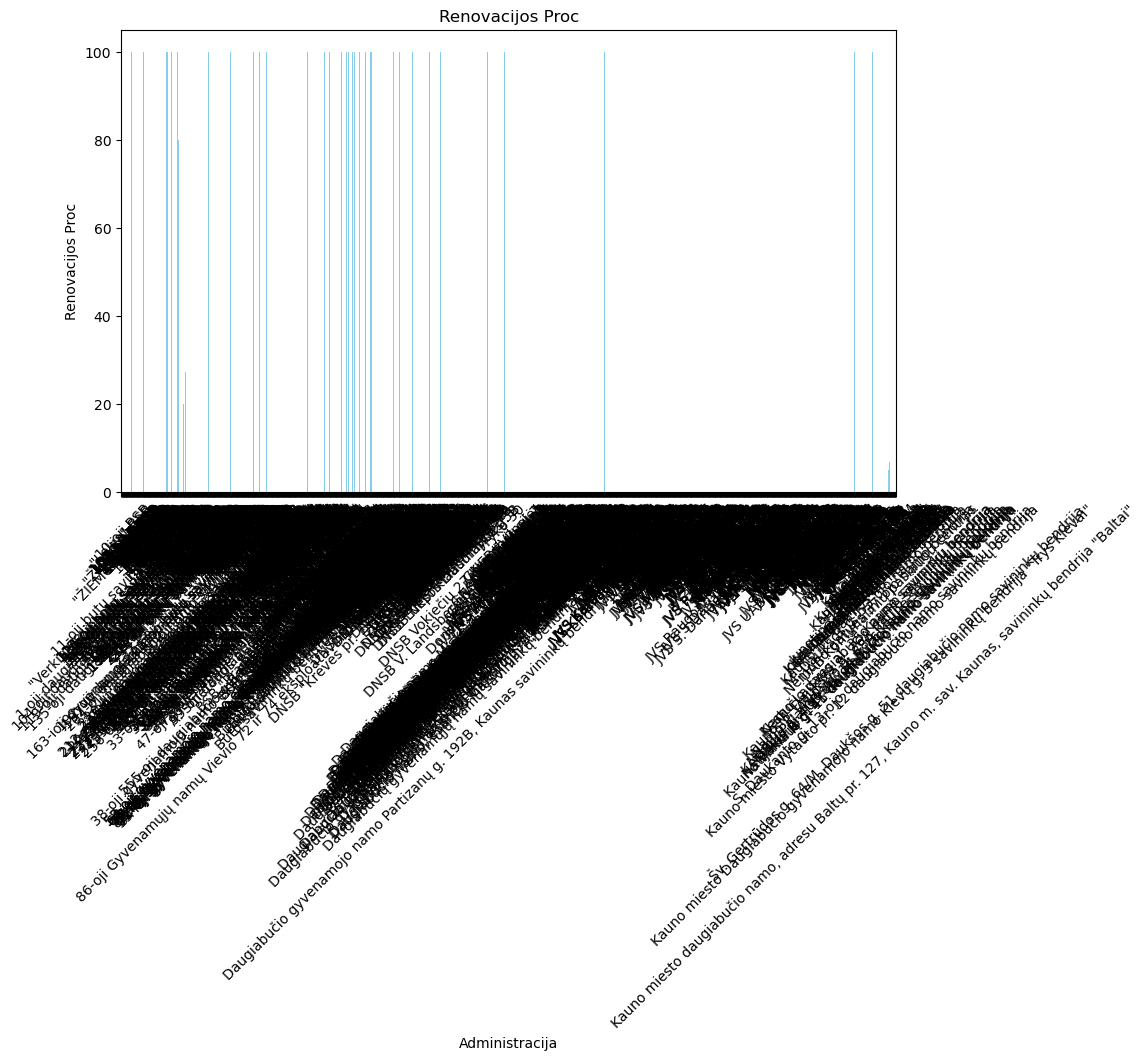

In [47]:
renovacija = df[df['bukle'] == 'Renovuotas'].groupby('valdytojas').size()
total = df.groupby('valdytojas').size()
print(renovacija)
print(total)
renovacija_proc = (renovacija / total * 100)
print(renovacija_proc)

print(df['bukle'].unique())


plt.figure(figsize=(10, 6))
# sns.barplot(x='valdytojas', y='renovacija_proc', data=renovacija_proc)
renovacija_proc.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.title('Renovacijos Proc')
plt.xlabel('Administracija')
plt.ylabel('Renovacijos Proc')
plt.show()

In [49]:
current_year = pd.Timestamp.now().year
df['construction_year'] = pd.to_datetime(df['statybos_metai'], errors='coerce')
df['age'] = current_year - df['construction_year'].dt.year

age_renovation_counts = df.groupby(['age', 'bukle']).size().unstack(fill_value=0)
age_renovation_percentages = (age_renovation_counts['Renovuotas'] / age_renovation_counts.sum(axis=1)) * 100

age_renovation_percentages_df = age_renovation_percentages.reset_index(name='Renovation_Percentage')
print(age_renovation_percentages_df)


       age  Renovation_Percentage
0      3.0                    0.0
1      5.0                    0.0
2      6.0                    0.0
3      7.0                    0.0
4      8.0                    0.0
..     ...                    ...
137  184.0                    0.0
138  186.0                    0.0
139  191.0                    0.0
140  200.0                    0.0
141  224.0                    0.0

[142 rows x 2 columns]


In [ ]:
df.dropna(subset=['stulpelio pavadinimas'])
df['stulpelis'].fillna(norima vertė)

In [ ]:
#Suraskite 2013-2023 metų eismo įvykuose daugiausiai kartų užfiksuotą automobilių a) gamintoją b) modelį. Kiekvienais metais tas gamintojas/modelis gali būti skirtingas - pateikite bar/barh grafikus.
# Kiek iš užfiksuotų automobilių turėjo Kasko draudimą?
# failai - JSON failai iš policijos svetainės - naudojote anksčiau juos.